# Подключаем библиотеки

In [ ]:
!pip install -q catboost shap
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 67.3MB 57kB/s 
     |████████████████████████████████| 358kB 45.1MB/s 
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import catboost
import catboost.datasets
import shap
import sklearn.model_selection
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import random
import math 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

In [ ]:
train_df = pd.read_csv("drive/MyDrive/content/train.csv")
test_df = pd.read_csv("drive/MyDrive/content/test.csv")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Вчисляем коэффициент Спирмана

In [ ]:
data = train_df.copy()
#data['AgeBuild'] = train_df['YrSold'] - train_df['YearBuilt']
#test_df['AgeBuild'] = test_df['YrSold'] - test_df['YearBuilt']

new_clm = []
clm_nan= []
for i in data.columns:
    if data[i].count() > 1200:
        new_clm.append(i)
        if data[i].count() < 1460:
            clm_nan.append(i)
data = data[new_clm] #убираем столбцы, где много пропусков

train_features = []
for clm in data.columns:
    if clm == 'SalePrice': continue
    stat = sps.spearmanr(data['SalePrice'], data[clm])[0]
    if abs(stat) > 0.3:
        train_features.append(clm)

In [ ]:
data[train_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   LotArea        1460 non-null   int64 
 2   LotShape       1460 non-null   object
 3   OverallQual    1460 non-null   int64 
 4   YearBuilt      1460 non-null   int64 
 5   YearRemodAdd   1460 non-null   int64 
 6   ExterQual      1460 non-null   object
 7   Foundation     1460 non-null   object
 8   BsmtFinSF1     1460 non-null   int64 
 9   TotalBsmtSF    1460 non-null   int64 
 10  HeatingQC      1460 non-null   object
 11  CentralAir     1460 non-null   object
 12  1stFlrSF       1460 non-null   int64 
 13  GrLivArea      1460 non-null   int64 
 14  FullBath       1460 non-null   int64 
 15  HalfBath       1460 non-null   int64 
 16  KitchenQual    1460 non-null   object
 17  TotRmsAbvGrd   1460 non-null   int64 
 18  Fireplaces     1460 non-null

In [ ]:
#строковые величины
s = [
     'MSZoning', 'LotShape', 'Foundation', 'HeatingQC', 'CentralAir', 
     'SaleCondition', 'ExterQual', 'KitchenQual'
     ] #>0.3
#s_2 = ['ExterQual', 'KitchenQual'] #>0.5

# Удаляем выбросы

In [ ]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] > (Q1 - 1.5 * IQR)) & (df[col] < (Q3 + 1.5 * IQR))]

data = remove_outliers(data, 'SalePrice')

# Random Forest только на числовых значениях


In [ ]:
data_for_rf = data[train_features].drop(columns = s)

train_X, test_X , train_y, test_y = sklearn.model_selection.train_test_split(
    data_for_rf,
    data['SalePrice'],
    train_size=0.8,
    random_state=2021
)


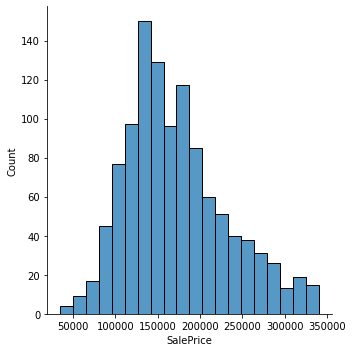

In [ ]:
sns.displot(train_y, bins=20)

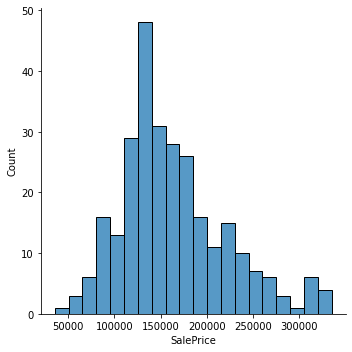

In [ ]:
sns.displot(test_y, bins=20)

In [ ]:
reg_rf = RandomForestRegressor(criterion = 'mae')
reg_rf.fit(train_X, train_y)

res = reg_rf.predict(test_X)
math.sqrt(sklearn.metrics.mean_squared_log_error(res, test_y))

0.13693523516182396

In [ ]:
scores = cross_val_score(reg_rf, train_X, train_y, cv=5, scoring='neg_mean_squared_log_error')
np.sqrt(-scores)

array([0.12390696, 0.16609727, 0.13784991, 0.14370563, 0.16490385])

In [ ]:
important_features = [i for i in zip(data_for_rf.columns, reg.feature_importances_)]
sorted(important_features, key = lambda p: -p[1])

[('OverallQual', 0.37398879584635963),
 ('GrLivArea', 0.14287399145971136),
 ('TotalBsmtSF', 0.0768104628619317),
 ('BsmtFinSF1', 0.05732052884822831),
 ('GarageArea', 0.05028100352773853),
 ('YearBuilt', 0.04830591064895224),
 ('1stFlrSF', 0.04529434142784211),
 ('LotArea', 0.044135328165586435),
 ('YearRemodAdd', 0.035565992732264524),
 ('GarageCars', 0.033108275534924764),
 ('OpenPorchSF', 0.025009898845767),
 ('WoodDeckSF', 0.017141937938253072),
 ('TotRmsAbvGrd', 0.016402053924974454),
 ('FullBath', 0.015751685799077247),
 ('Fireplaces', 0.011999433780277232),
 ('HalfBath', 0.006010358658111431)]

# CatBoost

In [ ]:
train_features_for_catboost = train_features.copy()

#добавляем признаки, которые не были взяты Спирманом
#но по графикам кажутся полезными
train_features_for_catboost.append('Neighborhood')
train_features_for_catboost.append('OverallCond')
train_features_for_catboost.append('PavedDrive')


Text(0, 0.5, 'Сумма')

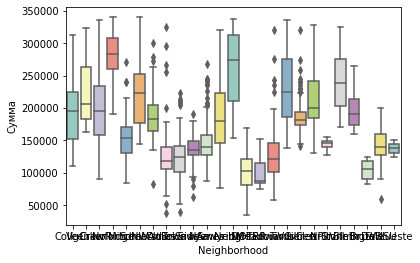

In [ ]:
sns.boxplot(x='Neighborhood', y='SalePrice', data=data, palette='Set3')
plt.ylabel('Сумма')

Text(0, 0.5, 'Сумма')

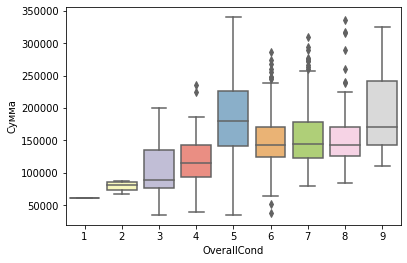

In [ ]:
sns.boxplot(x='OverallCond', y='SalePrice', data=data, palette='Set3')
plt.ylabel('Сумма')

Text(0, 0.5, 'Сумма')

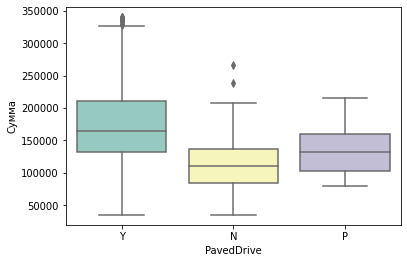

In [ ]:
sns.boxplot(x='PavedDrive', y='SalePrice', data=data, palette='Set3')
plt.ylabel('Сумма')

In [ ]:
data_1 = data[train_features_for_catboost]
data_1['SalePrice'] = data['SalePrice']

cat_features = [
     'MSZoning', 'LotShape', 'Foundation', 'HeatingQC', 'CentralAir', 
     'SaleCondition', 'ExterQual', 'KitchenQual'
     ] #>0.3

#некоторые числовые значения лучше рассматривать как категориальные
int_cat_features = [ 'HalfBath', 'OverallCond'] 

additional_cat_features = ['Neighborhood', 'PavedDrive'] 
cat_features.extend(int_cat_features + additional_cat_features)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Сумма')

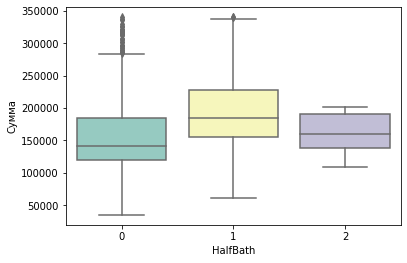

In [ ]:
sns.boxplot(x='HalfBath', y='SalePrice', data=data_1, palette='Set3')
plt.ylabel('Сумма')

In [ ]:
display(data_1['HalfBath'].value_counts())

0    893
1    494
2     12
Name: HalfBath, dtype: int64

Text(0, 0.5, 'Сумма')

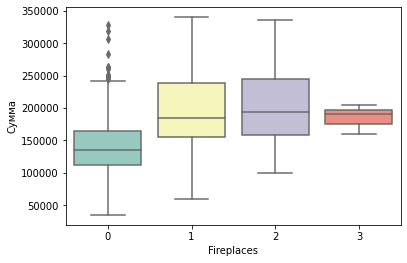

In [ ]:
sns.boxplot(x='Fireplaces', y='SalePrice', data=data_1, palette='Set3')
plt.ylabel('Сумма')

In [ ]:
display(data_1['Fireplaces'].value_counts())

0    689
1    607
2    100
3      3
Name: Fireplaces, dtype: int64

Text(0, 0.5, 'Сумма')

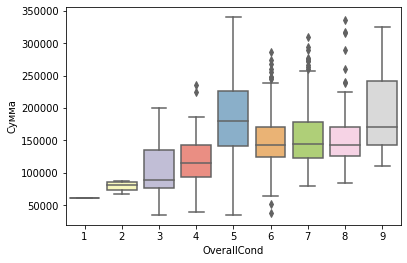

In [ ]:
sns.boxplot(x='OverallCond', y='SalePrice', data=data_1, palette='Set3')
plt.ylabel('Сумма')

In [ ]:
display(data_1['OverallCond'].value_counts())

5    769
6    248
7    203
8     72
4     57
3     25
9     20
2      4
1      1
Name: OverallCond, dtype: int64

In [ ]:
"""
sps.boxcox(data_1['SalePrice'])
data_1['SalePrice'] = sps.boxcox(data_1['SalePrice'])[0]
sns.displot(sps.boxcox(data_1['SalePrice']), bins=200)

real_value = {}
for i in test_y.index:
  real_value[i] = data['SalePrice'].iloc[i]
real_value = pd.Series(real_value )
y_box = clf.predict(test_X)
lambda_ =  -0.07692391328663316
sklearn.metrics.mean_squared_log_error(np.power((y_box * lambda_) + 1, 1 / lambda_), real_value)
"""

In [ ]:
train_X, test_X , train_y, test_y = sklearn.model_selection.train_test_split(
    data_1[train_features_for_catboost],
    data_1['SalePrice'],
    train_size=0.8,
    random_state=2021
)


train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    test_X,
    label=test_y,
    cat_features=cat_features
)
test_pool = catboost.Pool(
    test_X,
    label=test_y,
    cat_features=cat_features
)

In [ ]:
?catboost.CatBoostRegressor
!rm -rf 'catboost_pricing/snapshot.bkp'
catboost_train_dir = 'catboost_pricing'
reg = catboost.CatBoostRegressor(
    od_pval=0.01,
    od_wait=20,
    random_seed=2021,
    train_dir=catboost_train_dir,
    task_type='CPU',
    max_ctr_complexity=4,
    use_best_model=True
)
reg.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

In [ ]:
math.sqrt(sklearn.metrics.mean_squared_log_error(reg.predict(test_X), test_y))

0.11540497841002532

In [ ]:
""""
test_metrics = reg.eval_metrics(
    test_pool,
    metrics=['SMAPE', 'R2'],
    ntree_start=reg.best_iteration_ - 1,
    ntree_end=reg.best_iteration_,
    eval_period=1,
    thread_count=-1
)
test_metrics

# Оценка параметров для CatBoost

Processing trees...
128/996 trees processed	passed time: 186ms	remaining time: 1.26s
996/996 trees processed	passed time: 1.19s	remaining time: 0us
Processing documents...
128/1119 documents processed	passed time: 25.8ms	remaining time: 200ms
1119/1119 documents processed	passed time: 216ms	remaining time: 0us


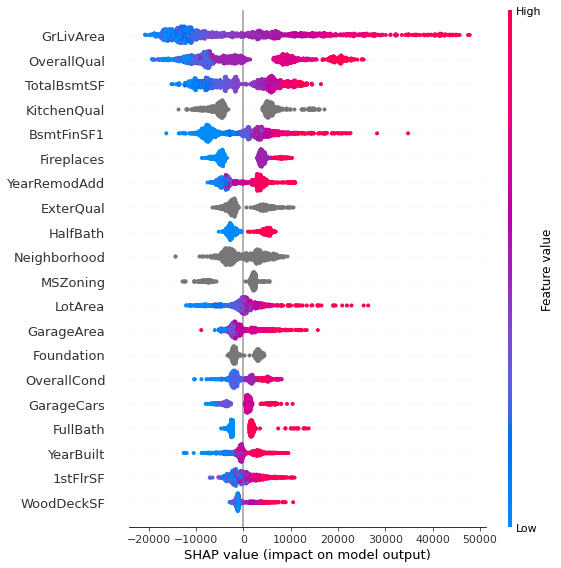

In [ ]:
shap_info = reg.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
shap.summary_plot(shap_values, train_X)

In [ ]:
"""
# Создание фигуры точечного графика
fig = go.Figure(data=go.Scatter(
    x=train_df[''], y=train_df['SalePrice']
))

# Отображение графика
fig.show()

# Random Forest with one hot encoding

тут всё стало хуже, но я попробовала

In [ ]:
train_df_with_ohe = train_df.copy()
train_features_with_ohe = []
#skip_features = ['OverallQual']
for feature in cat_features:
  #if feature in skip_features: continue
  enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
  enc.fit(train_df[feature].unique().reshape(-1, 1))
  list_of_columns = []
  for cat in enc.categories_[0]:
    list_of_columns.append(feature+'_' +str(cat))
  train_features_with_ohe.extend(list_of_columns)
  train_df_with_ohe[list_of_columns] = enc.transform(train_df[feature].values.reshape(-1, 1)).toarray().astype('int')
train_features_for_rf = train_features.copy()
train_features_for_rf.extend(train_features_with_ohe)

In [ ]:
"""
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] > (Q1 - 1.5 * IQR)) & (df[col] < (Q3 + 1.5 * IQR))]
"""

train_df_with_ohe = remove_outliers(train_df_with_ohe, 'SalePrice')
train_df_with_ohe = remove_outliers(train_df_with_ohe, 'LotArea')
train_df_with_ohe = remove_outliers(train_df_with_ohe, 'GrLivArea')
train_df_with_ohe = remove_outliers(train_df_with_ohe, 'TotalBsmtSF')
columns_of_df_with_ohe = train_df_with_ohe[train_features_for_rf].drop(columns = s).columns


In [ ]:
train_X, test_X , train_y, test_y = sklearn.model_selection.train_test_split(
    train_df_with_ohe[train_features_for_rf].drop(columns = s),
    train_df_with_ohe['SalePrice'],
    train_size=0.8,
    random_state=2021
)

reg_rf_with_ohe = RandomForestRegressor(criterion = 'mae')
reg_rf_with_ohe.fit(train_X, train_y)

res = reg_rf_with_ohe.predict(test_X)
math.sqrt(sklearn.metrics.mean_squared_log_error(res, test_y))

0.13536661018482765

In [ ]:
scores = cross_val_score(reg_rf_with_ohe, train_X, train_y, cv=5, scoring='neg_mean_squared_log_error')
np.sqrt(-scores).mean()

0.13885058925969568

In [ ]:
"""
important_features_3 = [i for i in zip(train_X.columns, reg_rf_with_ohe.feature_importances_)]
sorted(important_features_3, key = lambda p: -p[1])

# Запись ответа 

In [ ]:
data_test = test_df.copy()
data_test['MSZoning'] = data_test['MSZoning'].fillna(str(random.randint(0, 10)))
data_test['KitchenQual'] = data_test['KitchenQual'].fillna(str(random.randint(0, 10)))
data_test['BsmtFinSF1'] = data_test['BsmtFinSF1'].fillna(int(data_test['BsmtFinSF1'].mean())).astype('int64')
data_test['TotalBsmtSF'] = data_test['TotalBsmtSF'].fillna(int(data_test['TotalBsmtSF'].mean())).astype('int64')
data_test['GarageCars'] = data_test['GarageCars'].fillna(int(data_test['GarageCars'].mean())).astype('int64')
data_test['GarageArea'] = data_test['GarageArea'].fillna(int(data_test['GarageArea'].mean())).astype('int64')

#только для RF
"""
for feature in cat_features:
  enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
  enc.fit(train_df[feature].unique().reshape(-1, 1))
  list_of_columns = []
  for cat in enc.categories_[0]:
    list_of_columns.append(feature+'_' +str(cat))
  data_test[list_of_columns] = enc.transform(data_test[feature].values.reshape(-1, 1)).toarray().astype('int')

data_test_rf = data_test[train_features_for_rf].drop(columns = s)

In [ ]:
#data_test = data_test.fillna(0)
data_test_rf

In [ ]:
res_catboost = reg.predict(data_test[train_features_for_catboost])
#res_rf = reg_rf.predict(data_test_rf)
#res_rf_ex = reg_rf_with_ohe.predict(data_test_rf)

In [ ]:
id = ["Id"]
for i in test_df['Id'].values:
    id.append(i)   
res = res_catboost.tolist()
res.insert(0, 'SalePrice')

In [ ]:
np.savetxt('drive/MyDrive/content/sub_v_7.csv', [i for i in zip(id, res)], delimiter=',', fmt='%s')


# Результаты

Лучший результат был достигнут с применением катбуста 
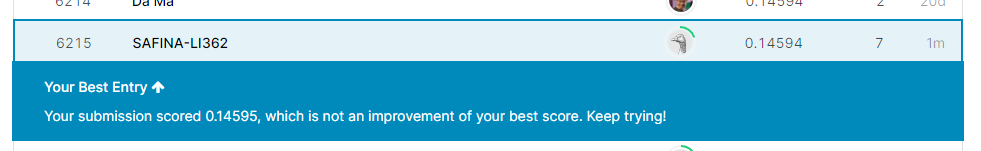

Самый первый Random Forest

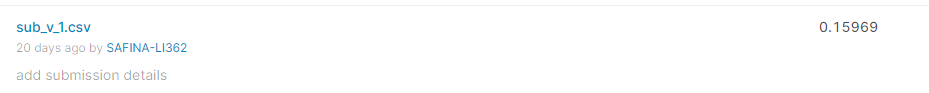

Random Forest с применением one hot encoding всё сильно узудшилось. Добавилось очень много параметров.

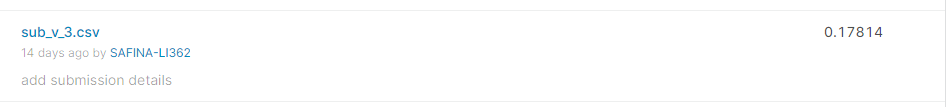